## Imports

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import requests
import zipfile as zpf

## netCDF files: Processing & exploration

In [3]:
folder = "/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/"

In [4]:
files = [path.join(folder, file) for file in listdir(folder)]
print(files)

['/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00034.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00142.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00151.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00280.nc']


In [4]:
ds = xr.open_dataset(files[0])

In [6]:
ds

<xarray.Dataset>
Dimensions:                               (nPoints_XY: 7857, nPoints_XYZ: 7857, nMetLines: 8760, nGroups: 1, nDatasets: 6, OutputOptionsUsed: 3, NumberOfTypesOfOutputPoint: 5)
Dimensions without coordinates: nPoints_XY, nPoints_XYZ, nMetLines, nGroups, nDatasets, OutputOptionsUsed, NumberOfTypesOfOutputPoint
Data variables: (12/24)
    PointX_XY                             (nPoints_XY) float32 ...
    PointY_XY                             (nPoints_XY) float32 ...
    PointName_XY                          (nPoints_XY) |S44 ...
    PointX_XYZ                            (nPoints_XYZ) float32 ...
    PointY_XYZ                            (nPoints_XYZ) float32 ...
    PointZ_XYZ                            (nPoints_XYZ) float32 ...
    ...                                    ...
    Dataset5                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Dataset6                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Output_Options_Description            (OutputOptionsUsed) |S14 ...
    Output_Options_Used                   (OutputOptionsUsed) int32 ...
    Output_Points_Type                    (NumberOfTypesOfOutputPoint) |S16 ...
    Number_Of_Output_Points_Of_Each_Type  (NumberOfTypesOfOutputPoint) int32 ...
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

There is a Dataset for each pollutant species, e.g. the NO2 data is contained in `Dataset2`.

Each pollutant dataset has a time dimension, represented by met lines, and a space dimension, represented by XYZ point number. Each pollutant dataset also has a Groups dimension, which indicates a subset of emission sources (here there is only one Group, for "All sources").

To identify the timestamp from the met lines, a separate `Met_Line` dataset contains timestamps encoded as YYYY_DDD_HH, with days numbered from 1 to 365.

To identify the spatial coordinates (OSGB (British National Grid)), the `PointX_XYZ`, `PointY_XYZ`, and `PointZ_XYZ` datasets contain the X, Y, and Z coordinates respectively.

The DataArray can be indexed like a `numpy` array e.g. to obtain only the concentrations through time at one spatial point e.g. `NO2_da[:,0,0].values`.

The DataArray can also be averaged over a dimension like a `numpy` array e.g. spatially averaged timeseries: `NO2_da.mean(axis=2).squeeze().values`. The `.squeeze()` function squeezes out the Groups dimension, since it has size 1.

### Time

Let's extract the datetime information from the Met_Line dataset:

In [6]:
def metline_to_datetime(i):
    numbers = str(i).replace("b", "").replace("'", "").split("_")
    return np.datetime64(f"{numbers[0]}")+ np.timedelta64(int(numbers[1])-1, "D") + np.timedelta64(int(numbers[2]), "h")

def extract_dataset_time_axis(ds):
    datetime_index = []
    for i in ds.Met_Line.values:
        datetime_index.append(metline_to_datetime(i))
    return datetime_index

In [64]:
datetime_index = extract_dataset_time_axis(ds)

Now we can plot a spatial average timeseries for NO2:

In [7]:
def plot_timeseries(dataframe, columns, title, units, figure_size=(8,4)):
    plt.figure(figsize=figure_size, dpi=300)
    for column in columns:
        dataframe[column].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

Missing values are assigned as `-999` during ADMS-Urban modelling, so we replace these with NaNs.

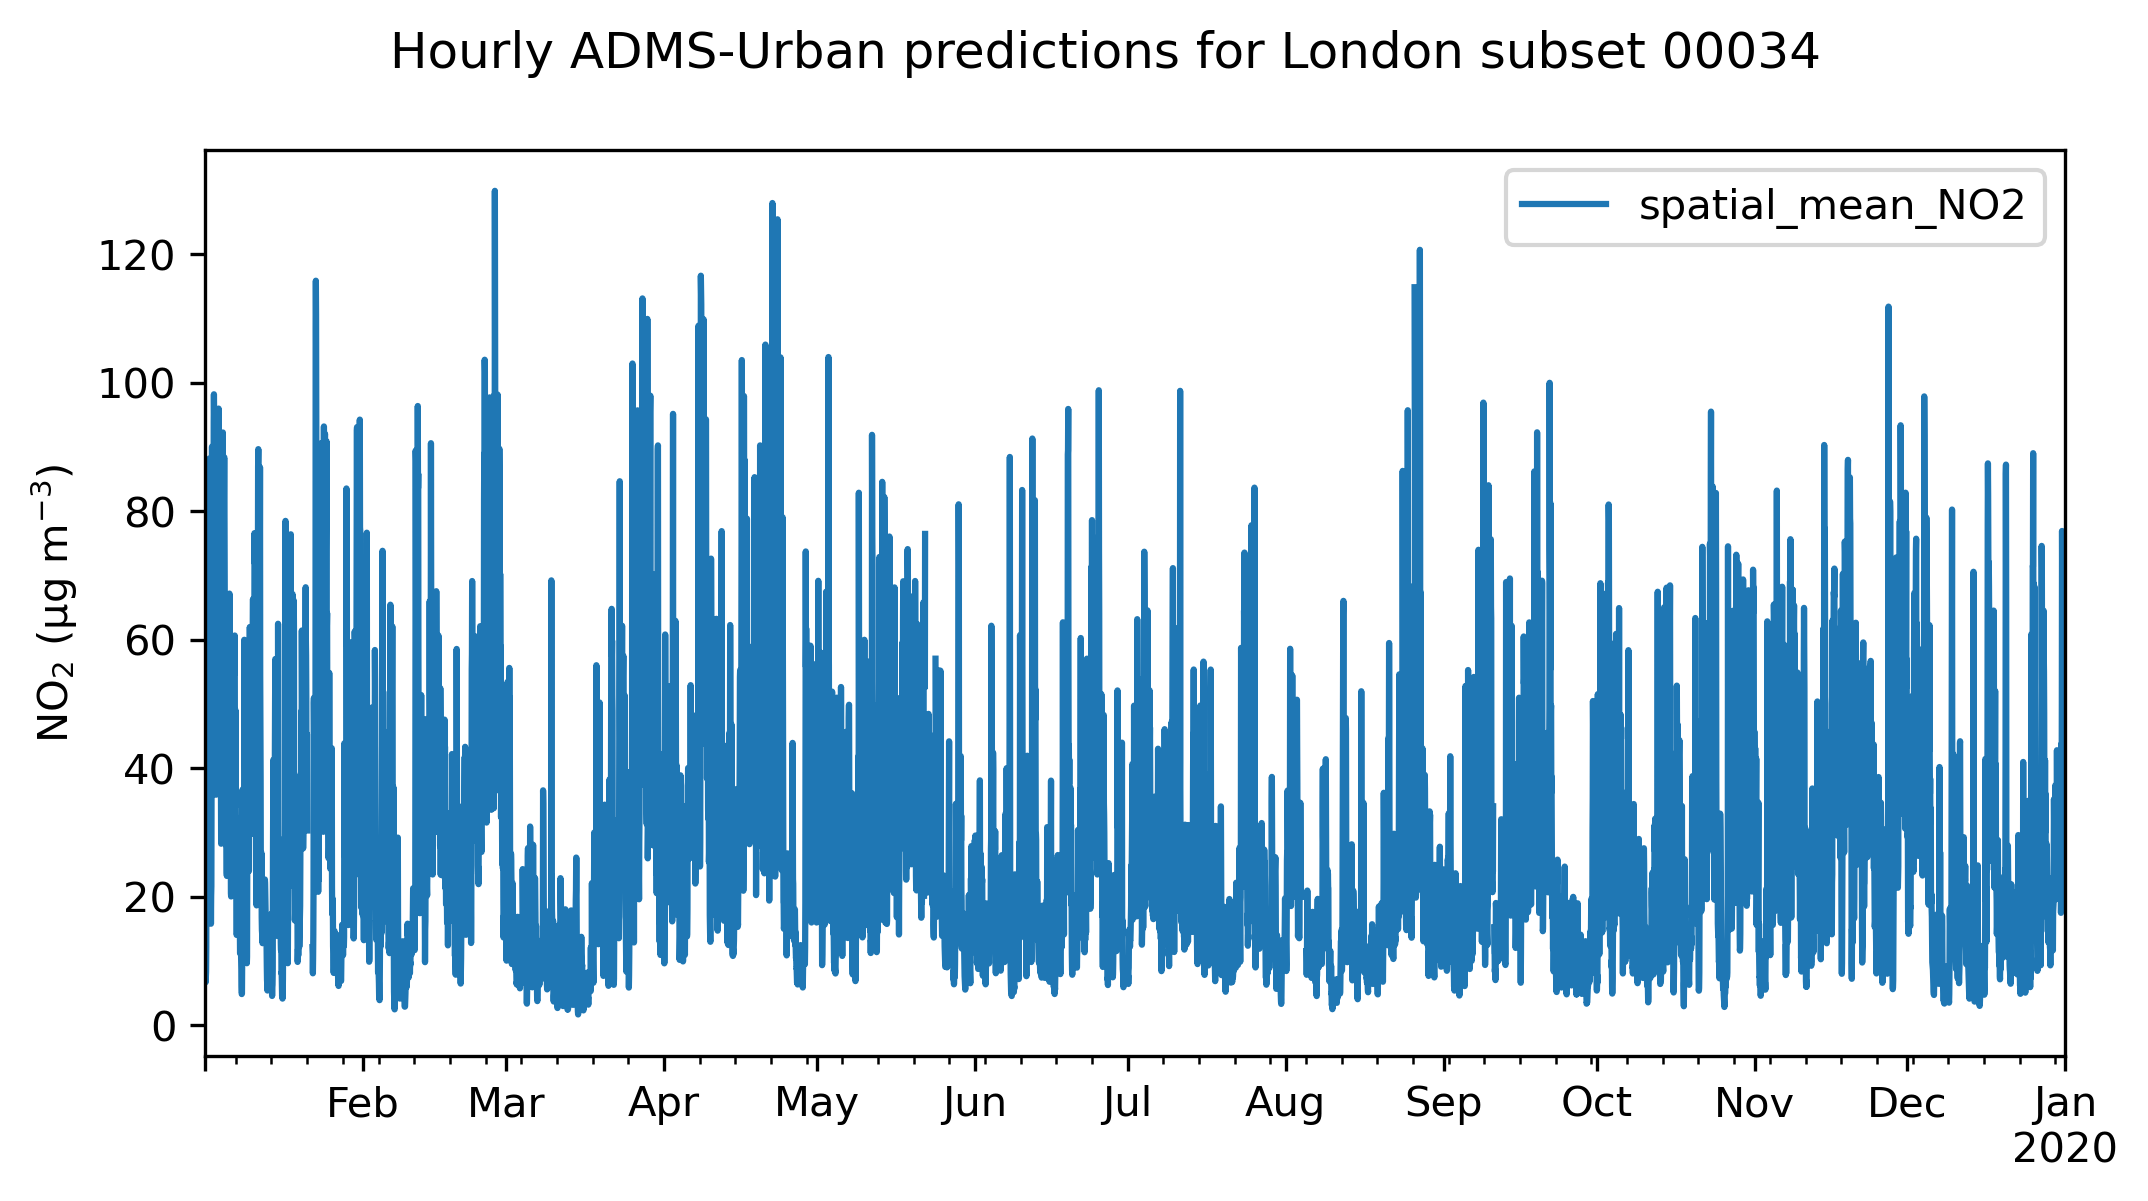

In [13]:
plot_timeseries(dataframe=pd.DataFrame(ds.Dataset2.mean(axis=2).squeeze().values, index=datetime_index, columns=["spatial_mean_NO2"]).replace(-999, np.nan), 
                columns=["spatial_mean_NO2"], 
                title="Hourly ADMS-Urban predictions for London subset 00034", 
                units="NO$_2$ (µg m$^{-3}$)")

### Space

The `PyBNG` library enables interconversion between the Ordnance Survey British National Grid (OS BNG) coordinates and latitude/longitude coordinates, which will be more useful for plotting and further analysis.

In [8]:
def PointXYZ_to_latlon(PointXs, PointYs):
    df = pd.DataFrame()
    for X, Y in zip(PointXs.astype(int), PointYs.astype(int)):
        latlon = PyBNG(easting=X, northing=Y).get_latlon()
        df = df.append([latlon])
    df.columns = ["latitude", "longitude"]
    df.reset_index(drop=True, inplace=True)
    return df

<AxesSubplot:>

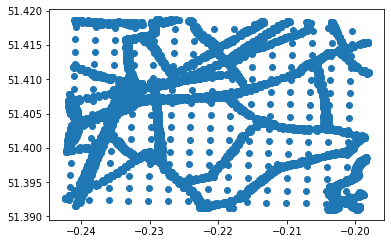

In [56]:
latlon_df = PointXYZ_to_latlon(ds.PointX_XYZ.values, 
                                  ds.PointY_XYZ.values)
gdf = gpd.GeoDataFrame(latlon_df, geometry=gpd.points_from_xy(latlon_df.longitude, latlon_df.latitude))

gdf.plot()

To plot this on a map of London, we can download the London borough GIS boundaries from the London Datastore:

In [11]:
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
tmp_folder = path.join(path.abspath(""), "tmp")
filename = path.basename(url)
filepath = path.join(tmp_folder, filename)
file = open(filepath, 'wb')
file.write(requests.get(url).content)
file.close()
zpf.ZipFile(filepath, 'r').extractall(tmp_folder)

In [20]:
shapefilepath = path.join(tmp_folder, "statistical-gis-boundaries-london", "ESRI",
                         "London_Borough_Excluding_MHW.shp")
london_boroughs_gdf = gpd.read_file(shapefilepath)

Convert to the latitude/longitude coordinate system by referencing the EPSG code `4326`:

In [21]:
london_boroughs_gdf.to_crs(epsg=4326, inplace=True)

In [9]:
def plot_on_map(data_geodataframe, map_geodataframe, column=None, title="Greater London", fontsize="25", figsize=(20,10), data_color=None, data_cmap=None, data_markersize=0.1, map_color="whitesmoke", map_edge_color="black", axis="off"):
    data_geodataframe.plot(column=column, ax=map_geodataframe.plot(figsize=figsize, color=map_color, edgecolor=map_edge_color),
                          color=data_color, cmap=data_cmap, markersize=data_markersize)
    plt.suptitle(title, fontsize=fontsize)
    plt.axis(axis)
    plt.show()

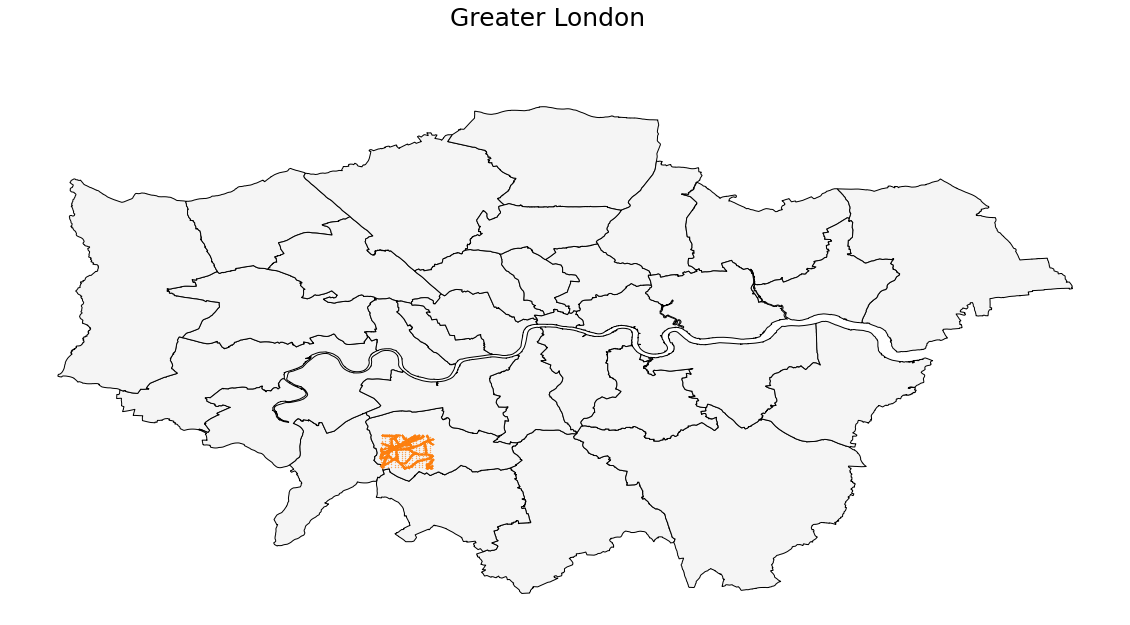

In [40]:
plot_on_map(gdf, london_boroughs_gdf, data_color="tab:orange")

Calculate the 2019 annual average NO2 concentration at each output point and join the GeoDataFrame with the spatial points:

In [34]:
space_gdf = gpd.GeoDataFrame(ds.Dataset2.mean(axis=0).squeeze().values, 
                  index=gdf.index, 
                  columns=["2019_mean_NO2"]).replace(-999, np.nan).join(gdf)

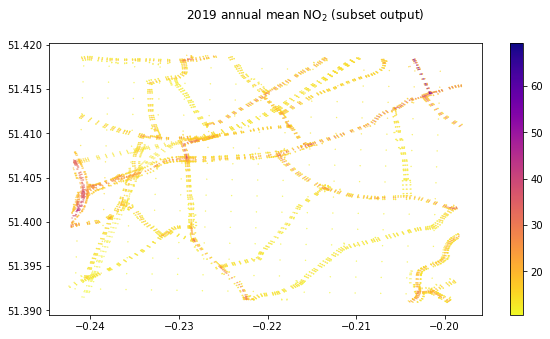

In [37]:
space_gdf.plot(column="2019_mean_NO2", figsize=(10,5), markersize=0.1, cmap="plasma_r")
plt.colorbar(
    plt.cm.ScalarMappable(
        cmap="plasma_r", 
        norm=plt.Normalize(space_gdf["2019_mean_NO2"].min(), space_gdf["2019_mean_NO2"].max())))
plt.suptitle("2019 annual mean NO$_2$ (subset output)")
plt.show()

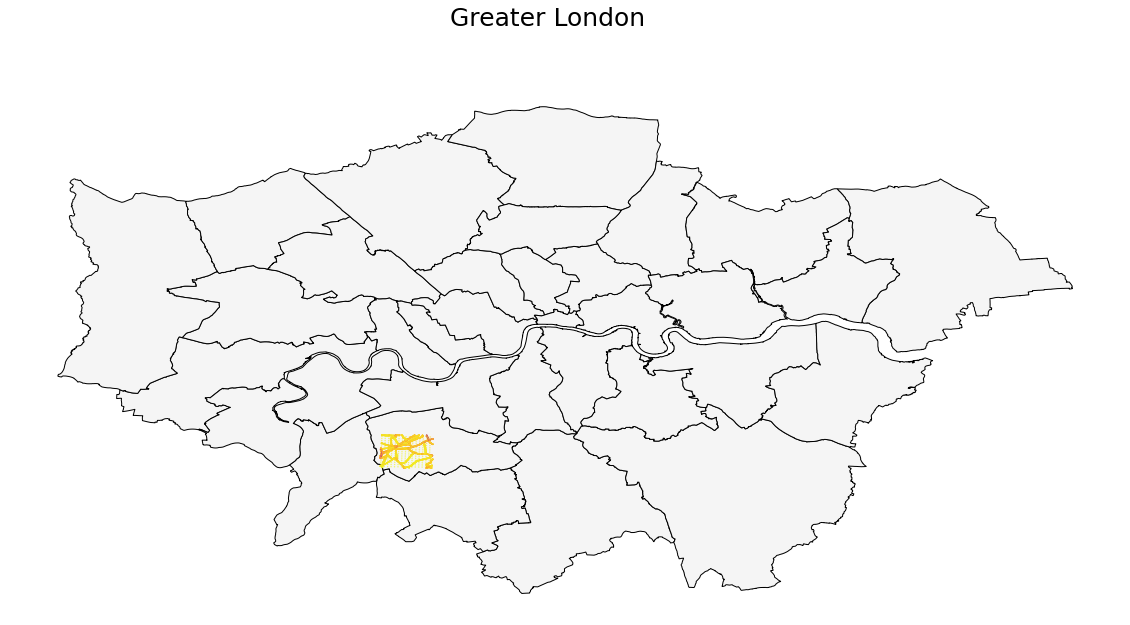

In [41]:
plot_on_map(space_gdf, london_boroughs_gdf, column="2019_mean_NO2", data_cmap="plasma_r")

### New Dataset

We can make a new Dataset containing all of the pollutant concentrations, as well as meteorological variables:

In [13]:
def process_dataset(ds):
    data_variables = {
        "NOx": (["time", "space"], ds.Dataset1.values.squeeze(), ds.Dataset1.attrs),
        "NO2": (["time", "space"], ds.Dataset2.values.squeeze(), ds.Dataset2.attrs),
        "PM10": (["time", "space"], ds.Dataset3.values.squeeze(), ds.Dataset3.attrs),
        "PM2.5": (["time", "space"], ds.Dataset4.values.squeeze(), ds.Dataset4.attrs),
        "CO2": (["time", "space"], ds.Dataset5.values.squeeze(), ds.Dataset5.attrs),
        "O3": (["time", "space"], ds.Dataset6.values.squeeze(), ds.Dataset6.attrs),
        "wind_speed_at_10m": (["time"], ds.Met_UAt10m.values.squeeze(), ds.Met_UAt10m.attrs),
        "wind_direction": (["time"], ds.Met_PHI.values.squeeze(), ds.Met_PHI.attrs)
                     }

    coords = {"datetime": (["time"], np.array(extract_dataset_time_axis(ds))),
         "latitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).latitude.values),
         "longitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).longitude.values)}

    attrs = ds.attrs

    return xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

Let's try loading multiple netCDF files:

In [14]:
files

['/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00034.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00142.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00151.nc',
 '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00280.nc']

In [69]:
ds_0 = process_dataset(xr.open_dataset(files[0]))
ds_1 = process_dataset(xr.open_dataset(files[1]))

We concatentate the xarray datasets along the `space` dimension:

In [23]:
ds_list = [process_dataset(xr.open_dataset(file)) for file in files]
new_ds = xr.concat(ds_list, "space")

In [24]:
new_ds

<xarray.Dataset>
Dimensions:            (time: 8760, space: 20025)
Coordinates:
    datetime           (time) datetime64[ns] 2019-01-01T01:00:00 ... 2020-01-01
    latitude           (space) float64 51.39 51.39 51.39 ... 51.44 51.44 51.44
    longitude          (space) float64 -0.2417 -0.2389 ... -0.2443 -0.2435
Dimensions without coordinates: time, space
Data variables:
    NOx                (time, space) float32 11.57 11.06 10.81 ... 62.24 72.23
    NO2                (time, space) float32 11.0 10.73 10.53 ... 44.66 47.33
    PM10               (time, space) float32 11.24 11.15 11.13 ... 43.48 45.53
    PM2.5              (time, space) float32 7.793 7.752 7.745 ... 33.37 34.33
    CO2                (time, space) float32 5.543e+03 5.192e+03 ... 3.353e+04
    O3                 (time, space) float32 60.41 60.52 ... 0.08722 0.08145
    wind_speed_at_10m  (space, time) float32 1.98 3.236 2.297 ... 2.9 1.962 1.36
    wind_direction     (space, time) float32 275.8 286.1 289.2 ... 110.5 130.1
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

Now we can make a Geopandas Dataframe for plotting:

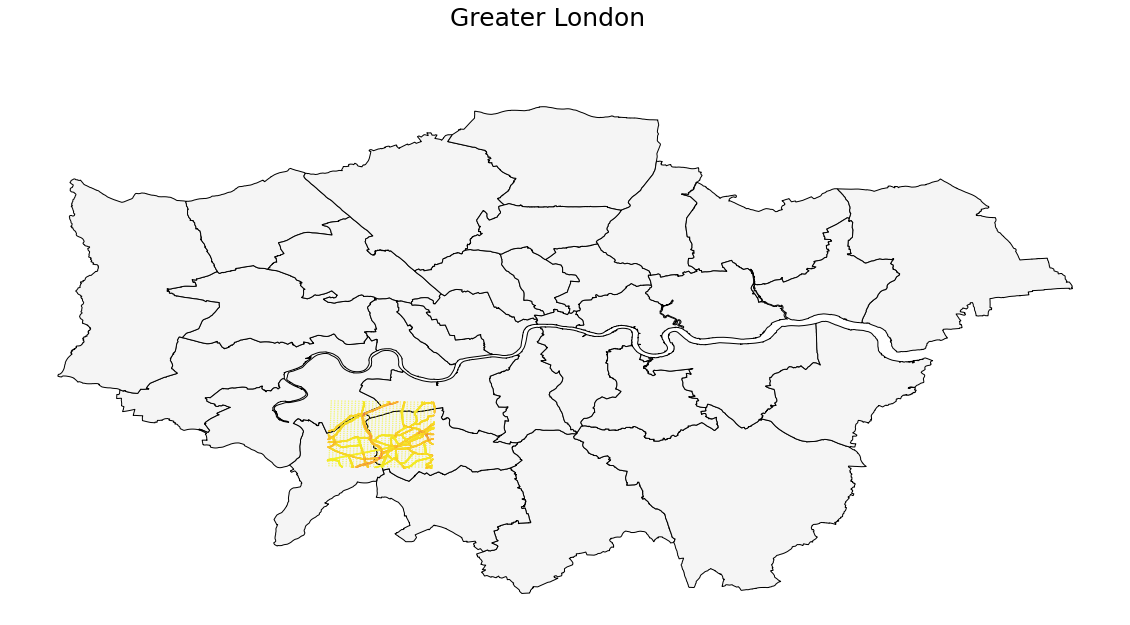

In [25]:
new_gdf = gpd.GeoDataFrame(new_ds.NO2.mean(axis=0).values, 
                 columns=["2019_mean_NO2"], 
                 geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))

plot_on_map(new_gdf, london_boroughs_gdf, column="2019_mean_NO2", data_cmap="plasma_r")